<a href="https://colab.research.google.com/github/Deca97/Credit_Score/blob/main/Credit_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Scoring Prediction for Credit Card Approval

## Overview
This project aims to develop a predictive model to estimate customer creditworthiness, helping **Pro National Bank** determine whether to approve or deny credit card applications. The model is designed to ensure interpretability, providing clear reasons for decisions made, which can be communicated to customers if their application is denied.

---

## Objectives
1. Predict the **creditworthiness** of customers using anonymized data.
2. Provide interpretable insights into the decision-making process.
3. Assist the bank in minimizing financial risks and improving customer trust.

---

## Dataset
The dataset consists of anonymized information about customers who have previously obtained credit cards and regularly pay their installments.

## Key Steps
### 1. Data Exploration
- Analyze feature distributions and relationships.
- Investigate the target variable `TARGET` for patterns or imbalances.
- Assess correlations and feature importance.

In [ ]:
# Importare le librerie necessarie
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Caricamento dei dati
data = pd.read_csv('/credit_scoring.csv')

# Analisi dei valori mancanti
print(data.isnull().sum())

print(data['TARGET'].value_counts())

data.info()
data.head()


ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64
TARGET
0    308705
1     29722
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  ob

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,424380.57,Working,Higher education,Civil marriage,Rented apartment,-11778.0,-4438.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,5008805,M,Y,Y,0,421593.52,Working,Higher education,Civil marriage,Rented apartment,-11777.0,-4459.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,5008806,M,Y,Y,0,110958.51,Working,Secondary / secondary special,Married,House / apartment,-21471.0,-1144.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,5008808,F,N,Y,0,267497.96,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18489.0,-3122.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,5008809,F,N,Y,0,263419.09,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19093.0,-3070.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


The dataset contains 5 numerical variables (CNT_CHILDREN, AMTINCOMETOTAL, DAYS_EMPLOYED, DAYS_BIRTH, and CNTFAMMEMBERS), while all the others are categorical.

The response variable TARGET appears to be heavily imbalanced towards 0 (NO).

The dataset contains missing values, particularly in the variable OCCUPATION_TYPE.

In [ ]:


#  Feature Engineering
data['AGE_YEARS'] = -data['DAYS_BIRTH'] // 365
data['YEARS_EMPLOYED'] = -data['DAYS_EMPLOYED'] // 365

data['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)


categorical_features = ['CODE_GENDER', 'OCCUPATION_TYPE', 'FLAG_EMAIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE', 'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
                        'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
numerical_features = ['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AGE_YEARS', 'YEARS_EMPLOYED']

for feature in numerical_features:
    if data[feature].isnull().any():
        data[feature].fillna(data[feature].median(), inplace=True)

for feature in categorical_features:
    data[feature].fillna(data[feature].mode()[0], inplace=True)

data=data.dropna()

data.info()
data.head()




<ipython-input-3-7a10e87271c2>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)
<ipython-input-3-7a10e87271c2>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

<class 'pandas.core.frame.DataFrame'>
Index: 338426 entries, 0 to 338425
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338426 non-null  int64  
 1   CODE_GENDER          338426 non-null  object 
 2   FLAG_OWN_CAR         338426 non-null  object 
 3   FLAG_OWN_REALTY      338426 non-null  object 
 4   CNT_CHILDREN         338426 non-null  int64  
 5   AMT_INCOME_TOTAL     338426 non-null  float64
 6   NAME_INCOME_TYPE     338426 non-null  object 
 7   NAME_EDUCATION_TYPE  338426 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL           3

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,AGE_YEARS,YEARS_EMPLOYED
0,5008804,M,Y,Y,0,424380.57,Working,Higher education,Civil marriage,Rented apartment,...,-4438.0,1.0,1.0,0.0,0.0,Unknown,2.0,0,32.0,12.0
1,5008805,M,Y,Y,0,421593.52,Working,Higher education,Civil marriage,Rented apartment,...,-4459.0,1.0,1.0,0.0,0.0,Unknown,2.0,0,32.0,12.0
2,5008806,M,Y,Y,0,110958.51,Working,Secondary / secondary special,Married,House / apartment,...,-1144.0,1.0,0.0,0.0,0.0,Security staff,2.0,0,58.0,3.0
3,5008808,F,N,Y,0,267497.96,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3122.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1,50.0,8.0
4,5008809,F,N,Y,0,263419.09,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3070.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1,52.0,8.0


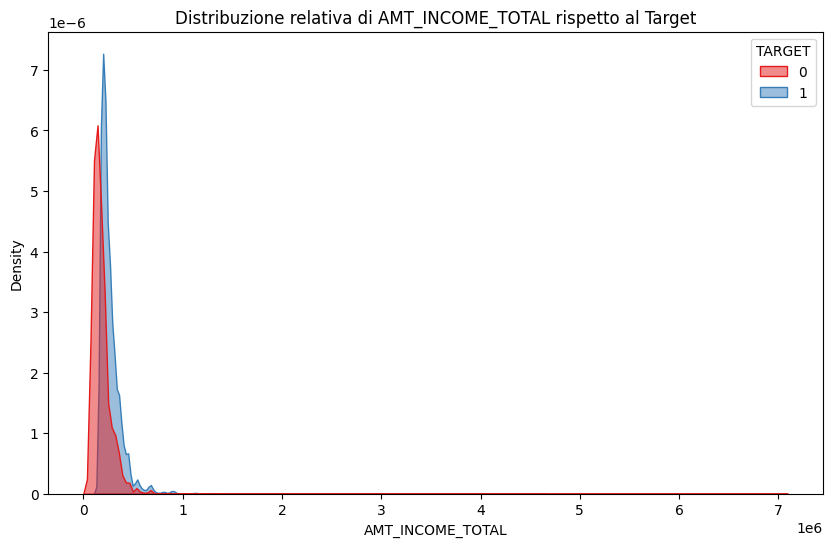

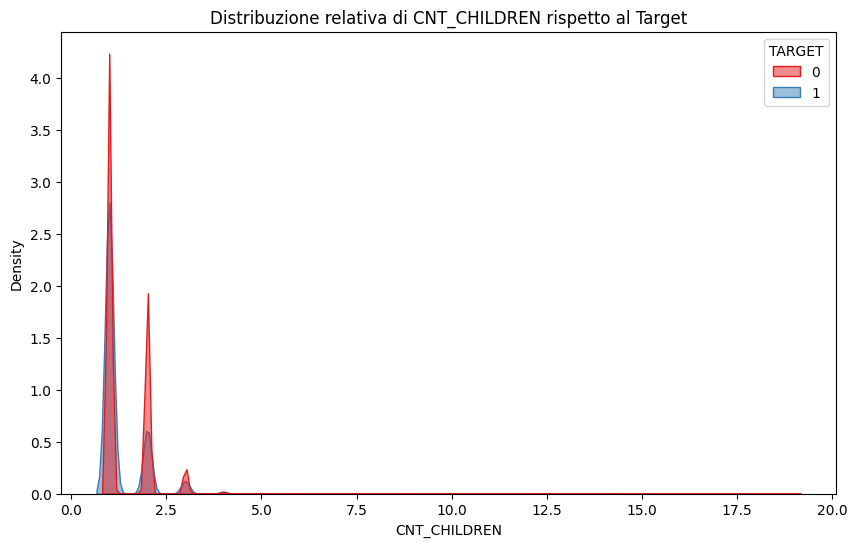

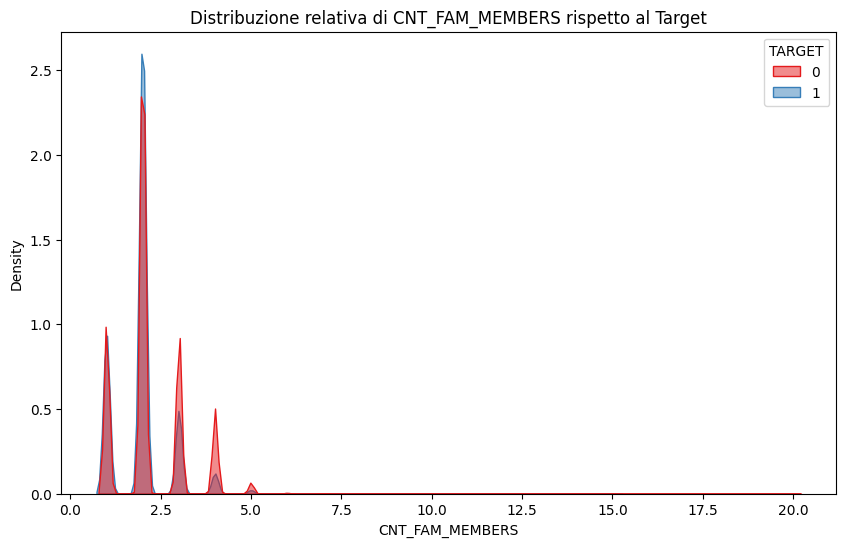

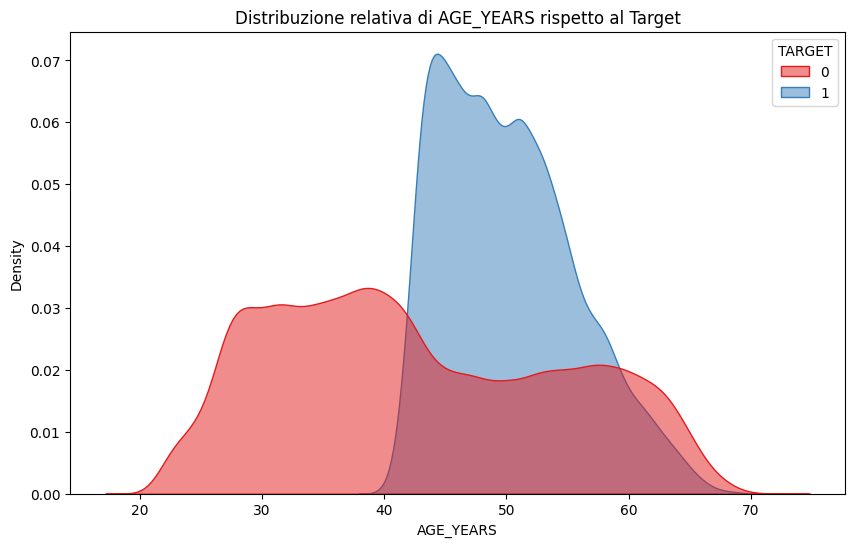

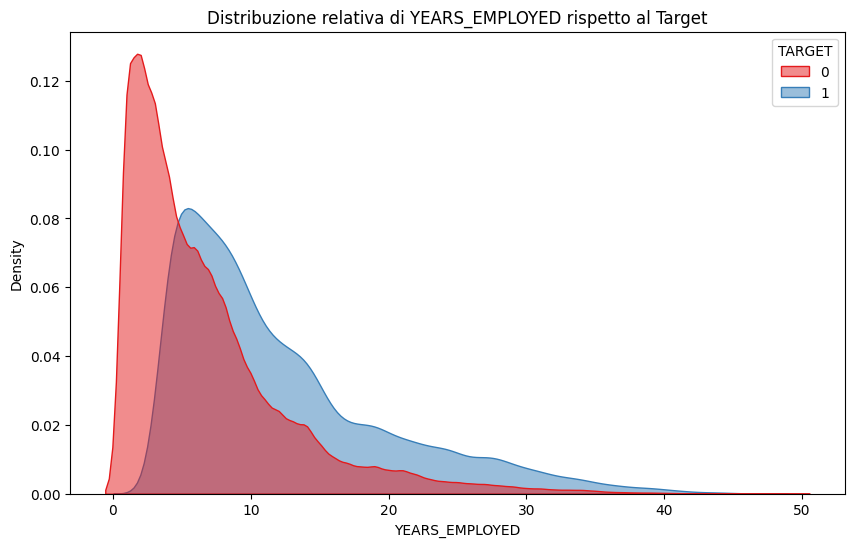

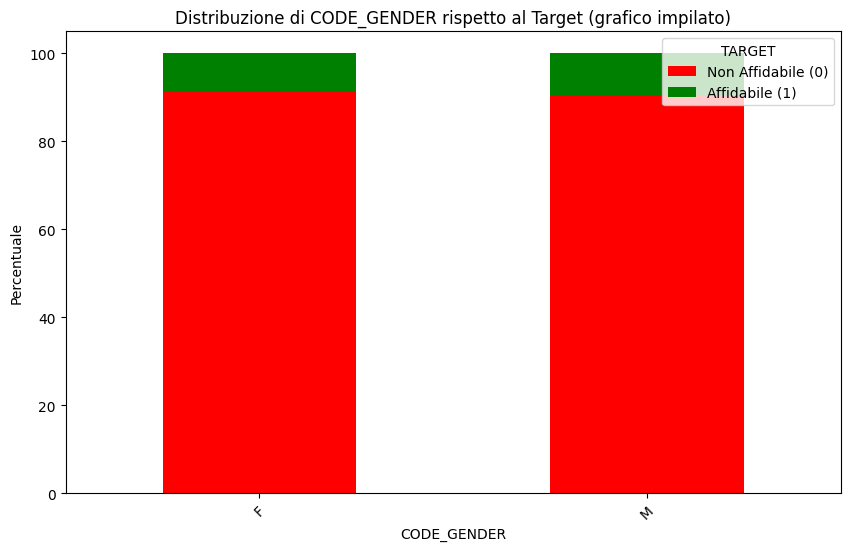

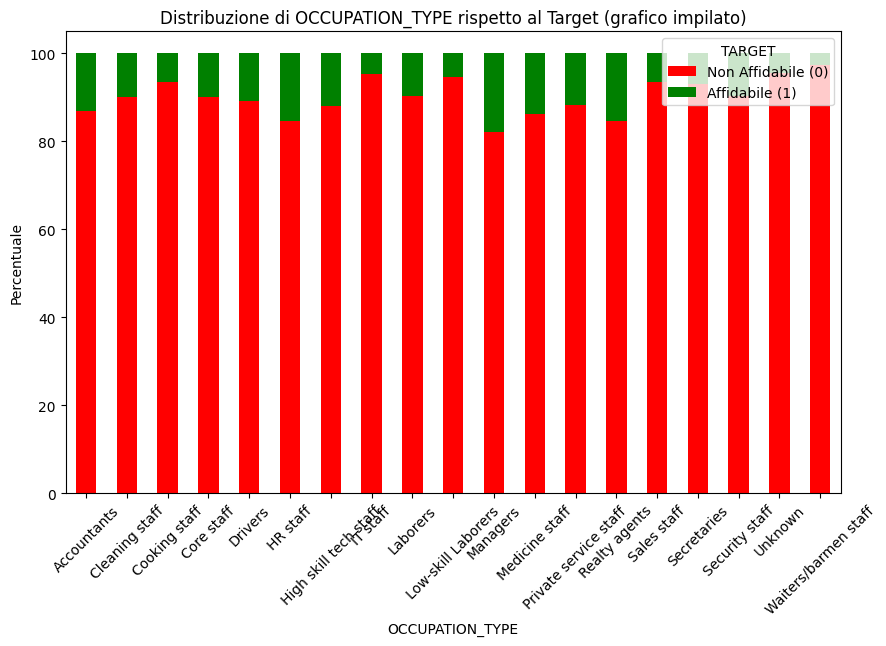

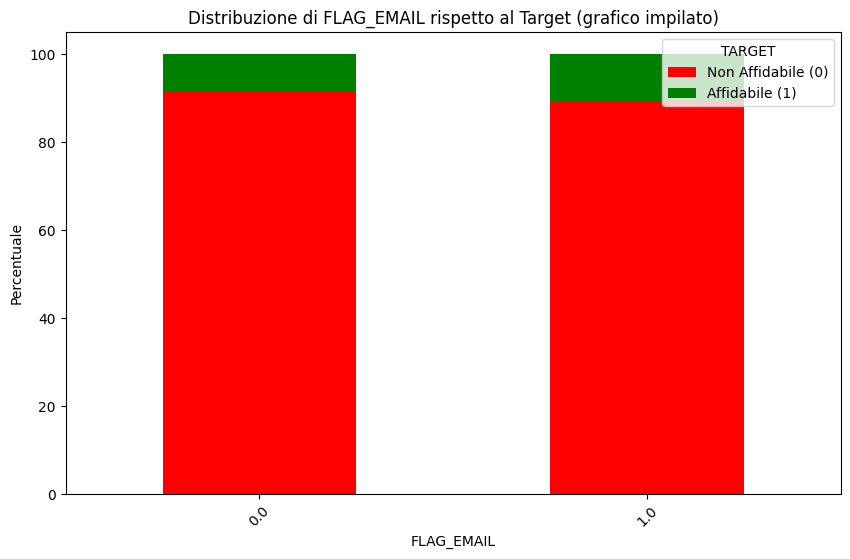

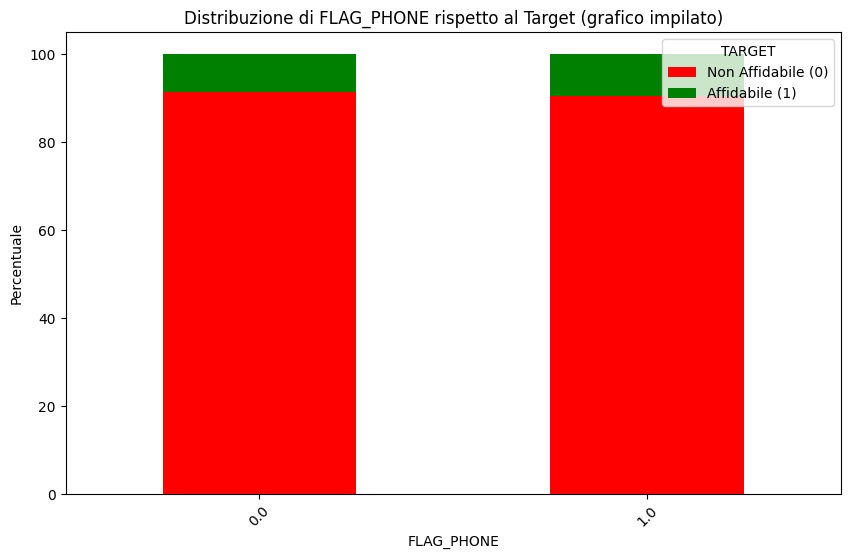

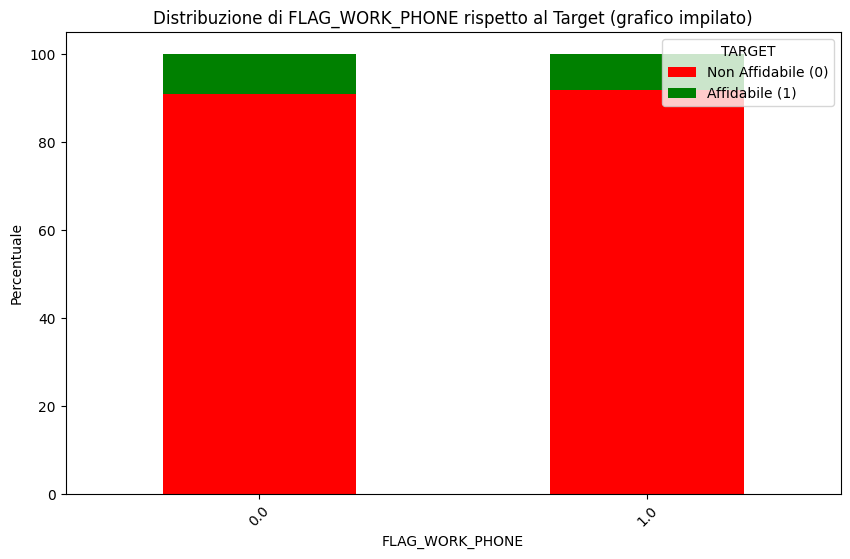

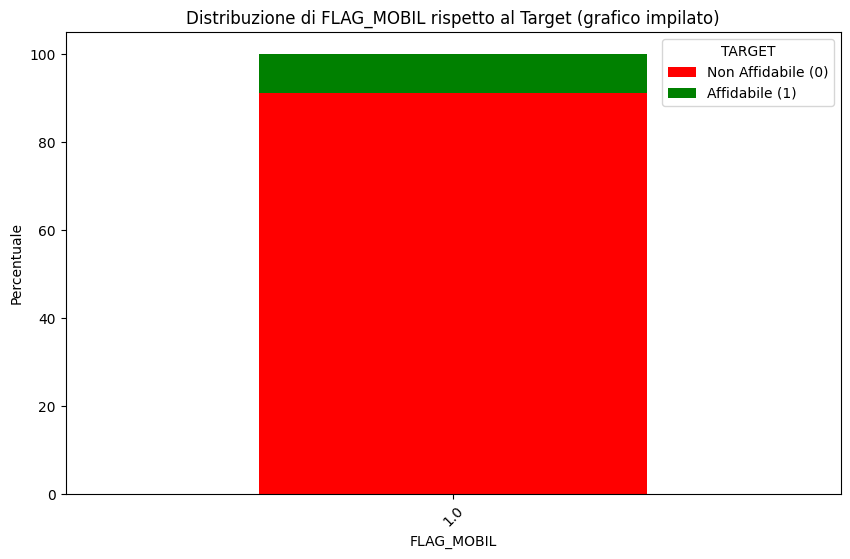

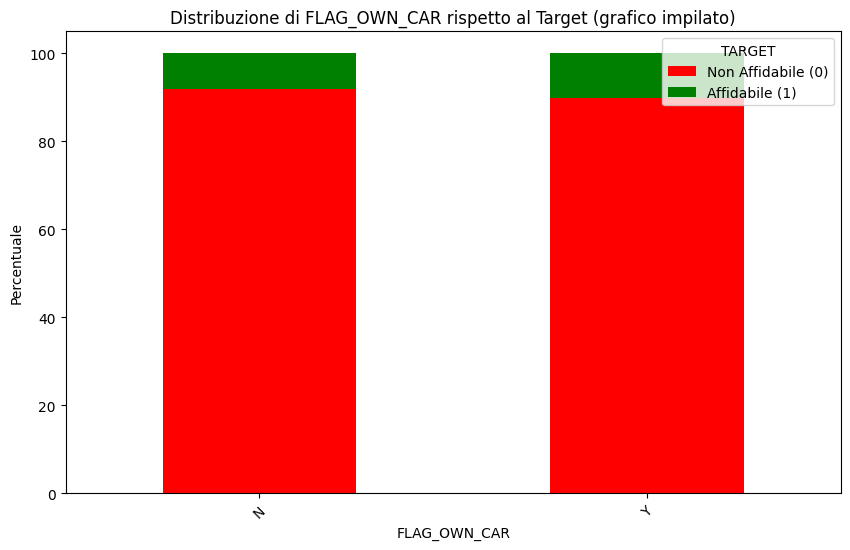

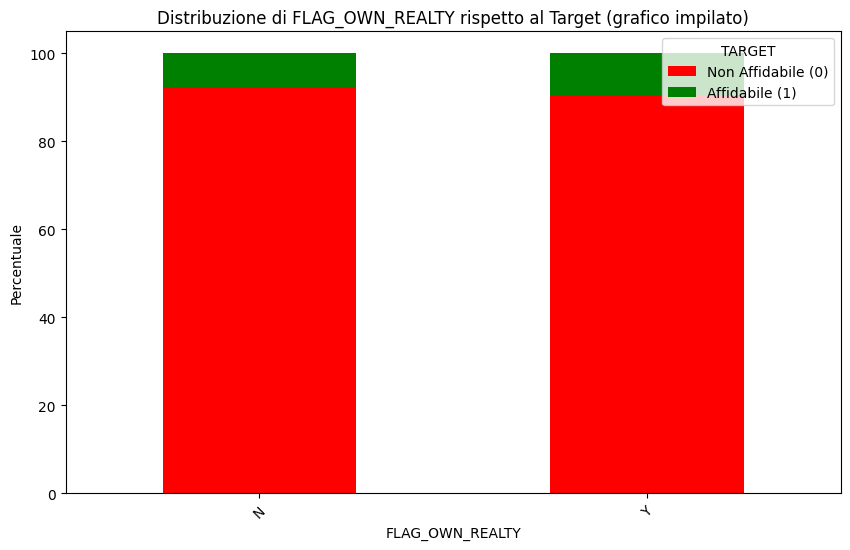

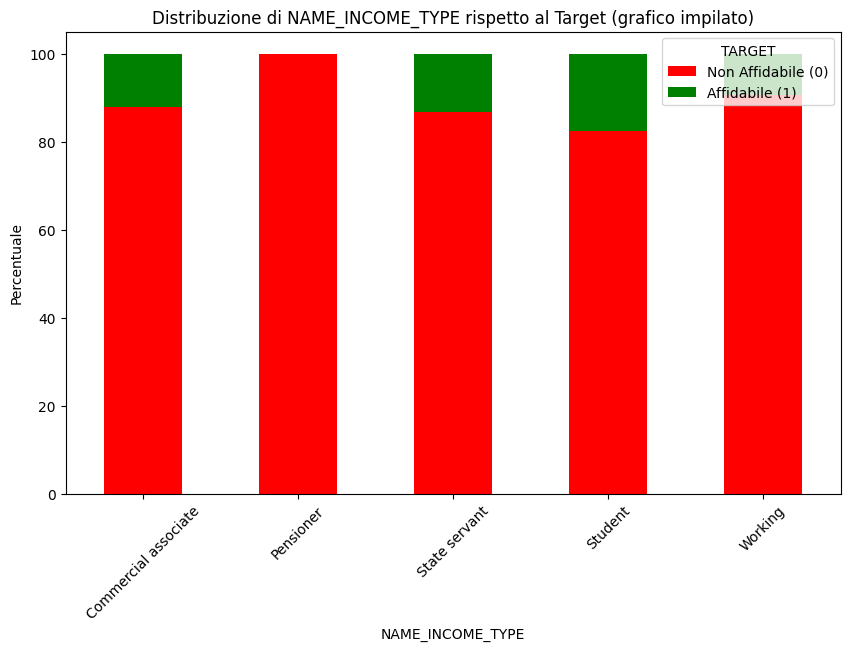

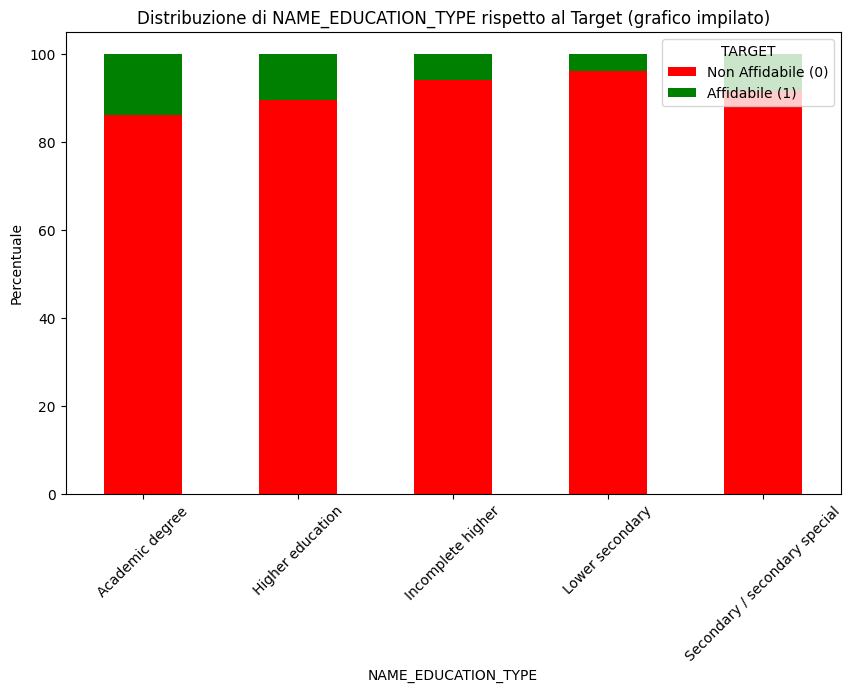

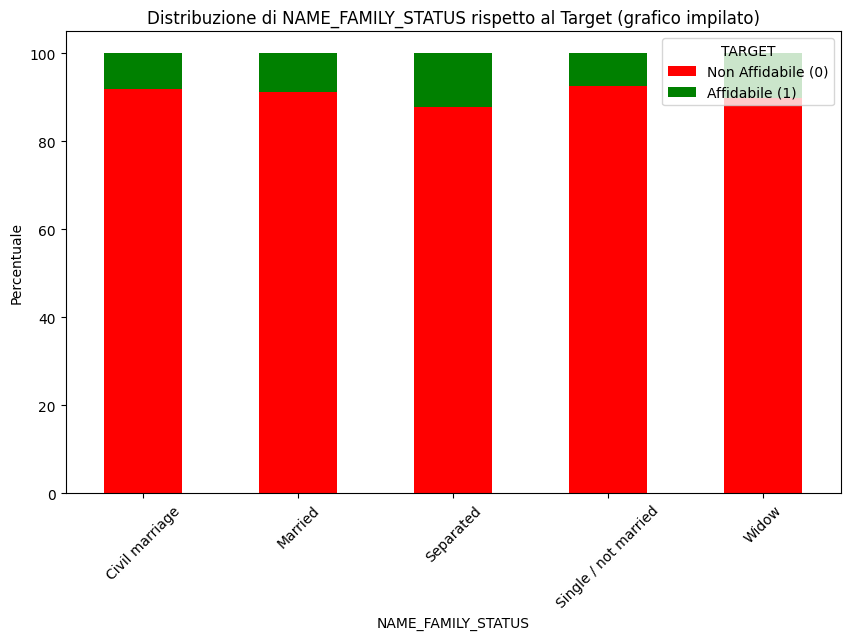

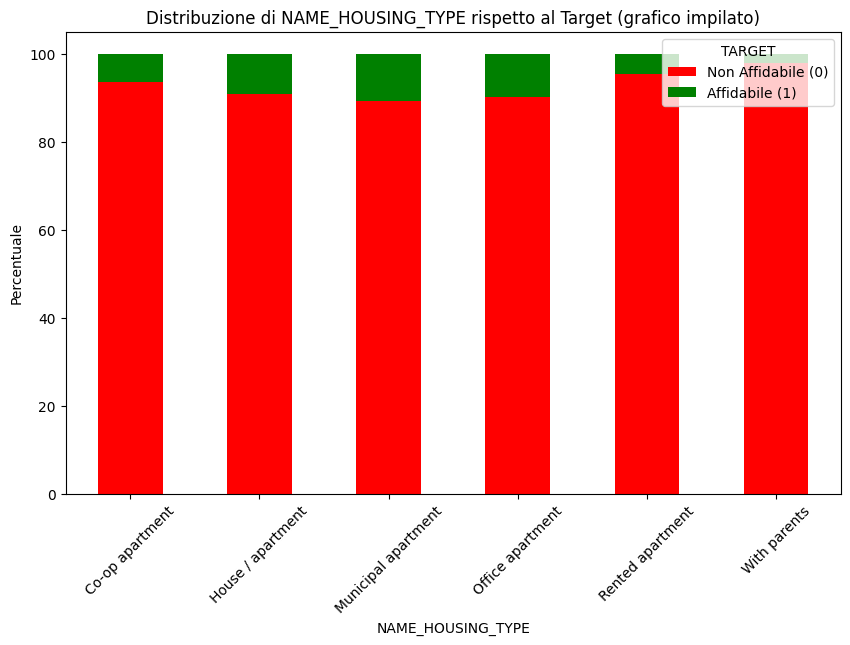

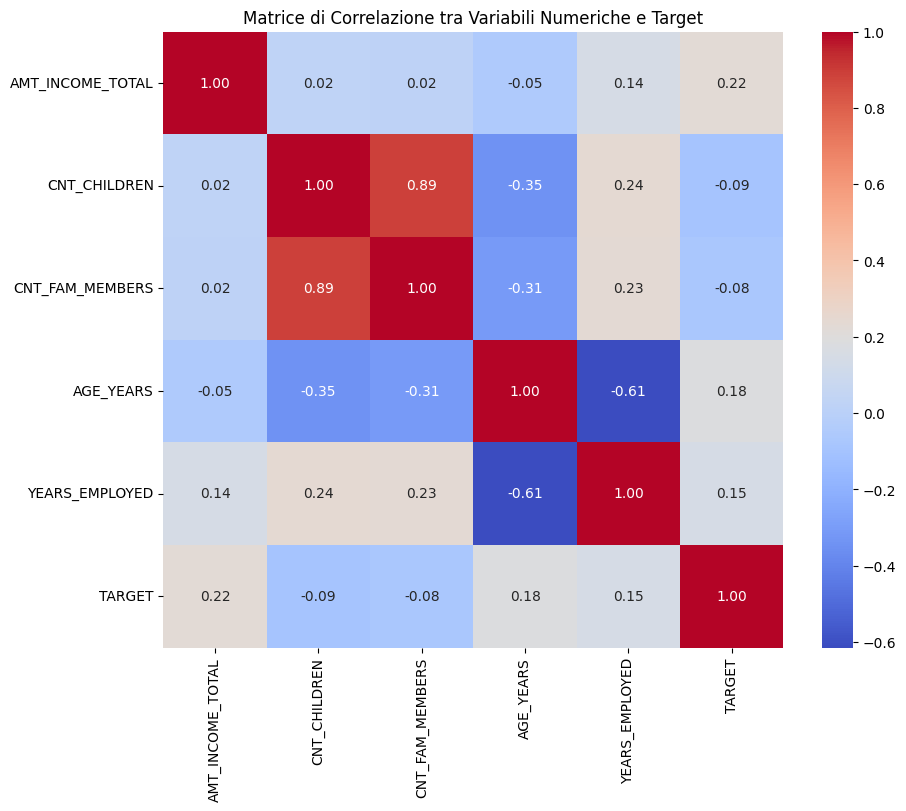


Percentuale di affidabilità per la variabile CODE_GENDER:

TARGET               0         1
CODE_GENDER                     
F            91.510870  8.489130
M            90.612699  9.387301

Percentuale di affidabilità per la variabile OCCUPATION_TYPE:

TARGET                         0          1
OCCUPATION_TYPE                            
Accountants            86.841462  13.158538
Cleaning staff         90.008707   9.991293
Cooking staff          93.581946   6.418054
Core staff             90.046828   9.953172
Drivers                89.170829  10.829171
HR staff               84.656085  15.343915
High skill tech staff  88.125980  11.874020
IT staff               95.412844   4.587156
Laborers               90.340172   9.659828
Low-skill Laborers     94.574096   5.425904
Managers               82.142857  17.857143
Medicine staff         86.338379  13.661621
Private service staff  88.374596  11.625404
Realty agents          84.741784  15.258216
Sales staff            93.513838   6.486

<ipython-input-4-fd404a1d21a1>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TARGET', data=data, palette='Set1')


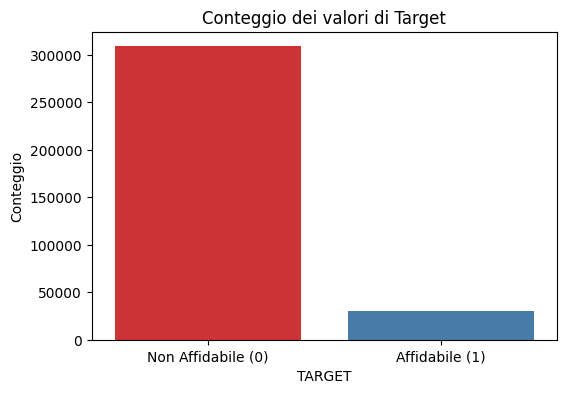

In [ ]:

# Creare grafici di densità per vedere la distribuzione relativa delle variabili numeriche rispetto al target
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=data[data[feature]>0], x=feature, hue="TARGET", fill=True, common_norm=False, palette="Set1", alpha=0.5)
    plt.title(f"Distribuzione relativa di {feature} rispetto al Target")
    plt.show()

# Creare grafici a barre impilate (stacked bar plot) per le variabili categoriche rispetto al target
for feature in categorical_features:
    # Creare una tabella pivot con le percentuali per target
    crosstab = pd.crosstab(data[feature], data['TARGET'], normalize='index') * 100

    # Creare il grafico a barre impilate
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green'])

    # Aggiungere titolo e label agli assi
    plt.title(f"Distribuzione di {feature} rispetto al Target (grafico impilato)")
    plt.ylabel('Percentuale')
    plt.legend(title='TARGET', loc='upper right', labels=['Non Affidabile (0)', 'Affidabile (1)'])
    plt.xticks(rotation=45)
    plt.show()

# Calcolare la correlazione tra variabili numeriche e target
correlation_matrix = data[numerical_features + ['TARGET']].corr()

# Visualizzare la matrice di correlazione con una heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice di Correlazione tra Variabili Numeriche e Target")
plt.show()

# Tabella di frequenza per visualizzare le percentuali per le variabili categoriche rispetto al target
for feature in categorical_features:
    freq_table = pd.crosstab(data[feature], data['TARGET'], normalize='index') * 100
    print(f"\nPercentuale di affidabilità per la variabile {feature}:\n")
    print(freq_table)

# Conteggio dei valori di TARGET
target_counts = data['TARGET'].value_counts()
print(target_counts)

# Visualizzazione con un grafico countplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=data, palette='Set1')
plt.title('Conteggio dei valori di Target')
plt.xlabel('TARGET')
plt.ylabel('Conteggio')
plt.xticks(ticks=[0, 1], labels=['Non Affidabile (0)', 'Affidabile (1)'])
plt.show()

The variables with the greatest influence on the response appear to be AMT_INCOME_TOTAL, AGE_YEARS, YEARS_EMPLOYED, NAME_INCOME_TYPE, and NAME_EDUCATION_TYPE.

For now, we will remove the other variables and apply encoding to the categorical variables.

In [ ]:
from sklearn.model_selection import train_test_split
# Definizione del target

numerical_features = ['AMT_INCOME_TOTAL', 'AGE_YEARS', 'YEARS_EMPLOYED']
categorical_features = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE']

X = data[categorical_features + numerical_features]
y = data['TARGET']


# Preprocessing
encoding = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), categorical_features)])

X = encoding.fit_transform(X)

encoded_columns = encoding.transformers_[0][1].get_feature_names_out(categorical_features)

X_en = pd.DataFrame(X, columns=encoded_columns)


X_en_df = pd.concat([X_en, data[numerical_features]], axis=1)

print(X_en_df.info())











<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338426 entries, 0 to 338425
Data columns (total 13 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   NAME_INCOME_TYPE_Commercial associate              338426 non-null  float64
 1   NAME_INCOME_TYPE_Pensioner                         338426 non-null  float64
 2   NAME_INCOME_TYPE_State servant                     338426 non-null  float64
 3   NAME_INCOME_TYPE_Student                           338426 non-null  float64
 4   NAME_INCOME_TYPE_Working                           338426 non-null  float64
 5   NAME_EDUCATION_TYPE_Academic degree                338426 non-null  float64
 6   NAME_EDUCATION_TYPE_Higher education               338426 non-null  float64
 7   NAME_EDUCATION_TYPE_Incomplete higher              338426 non-null  float64
 8   NAME_EDUCATION_TYPE_Lower secondary                338426 non-null  float6

### 2. Model Development
- Use machine learning algorithms to predict customer creditworthiness.
- Ensure interpretability through techniques such as:
  - Feature importance analysis.
  - Decision tree visualization.

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_en_df, y, test_size=0.3, random_state=42)

In [ ]:
# Creazione del modello (Random Forest)
model = DecisionTreeClassifier(class_weight = 'balanced', max_depth=3, random_state=42 )


# Addestrare il modello
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42)

### 3. Evaluation and Reporting
- Measure model performance using metrics such as AUC, accuracy, precision, recall, and F1 score.
- Provide insights to justify predictions in both approval and denial cases.

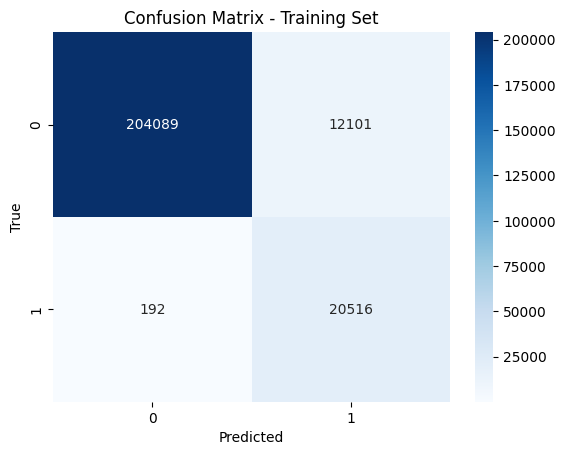

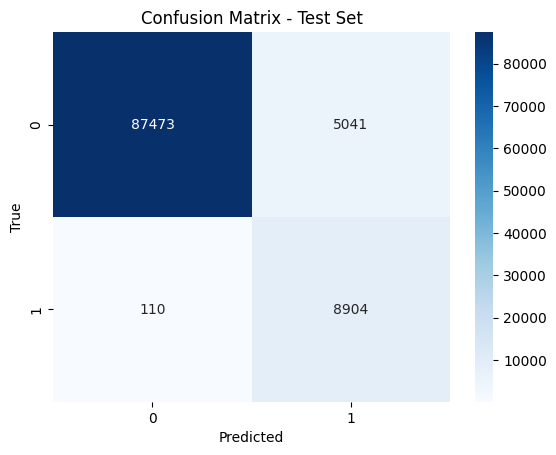

=== Classification Report (Train Set) ===
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    216190
           1       0.63      0.99      0.77     20708

    accuracy                           0.95    236898
   macro avg       0.81      0.97      0.87    236898
weighted avg       0.97      0.95      0.95    236898


=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     92514
           1       0.64      0.99      0.78      9014

    accuracy                           0.95    101528
   macro avg       0.82      0.97      0.87    101528
weighted avg       0.97      0.95      0.95    101528



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, classification_report, ConfusionMatrixDisplay


#  Previsioni sul training set e sul test set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#  Calcolo delle metriche
# Matrice di confusione
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Visualizzazione della matrice di confusione per il training set
plot_confusion_matrix(conf_matrix_train, title='Confusion Matrix - Training Set')

# Visualizzazione della matrice di confusione per il test set
plot_confusion_matrix(conf_matrix_test, title='Confusion Matrix - Test Set')



# Stampa del Classification Report per il train set
print("=== Classification Report (Train Set) ===")
print(classification_report(y_train, y_train_pred))

# Stampa del Classification Report per il test set
print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_test_pred))




##Results
* Overall, the model's accuracy is 95% and does not seem to be affected by overfitting.


Feature Importance for Random Forest:
                                  Feature  Importance
10                       AMT_INCOME_TOTAL    0.425300
11                              AGE_YEARS    0.347038
12                         YEARS_EMPLOYED    0.227662
0   NAME_INCOME_TYPE_Commercial associate    0.000000
1              NAME_INCOME_TYPE_Pensioner    0.000000
2          NAME_INCOME_TYPE_State servant    0.000000
3                NAME_INCOME_TYPE_Student    0.000000
4                NAME_INCOME_TYPE_Working    0.000000
5     NAME_EDUCATION_TYPE_Academic degree    0.000000
6    NAME_EDUCATION_TYPE_Higher education    0.000000


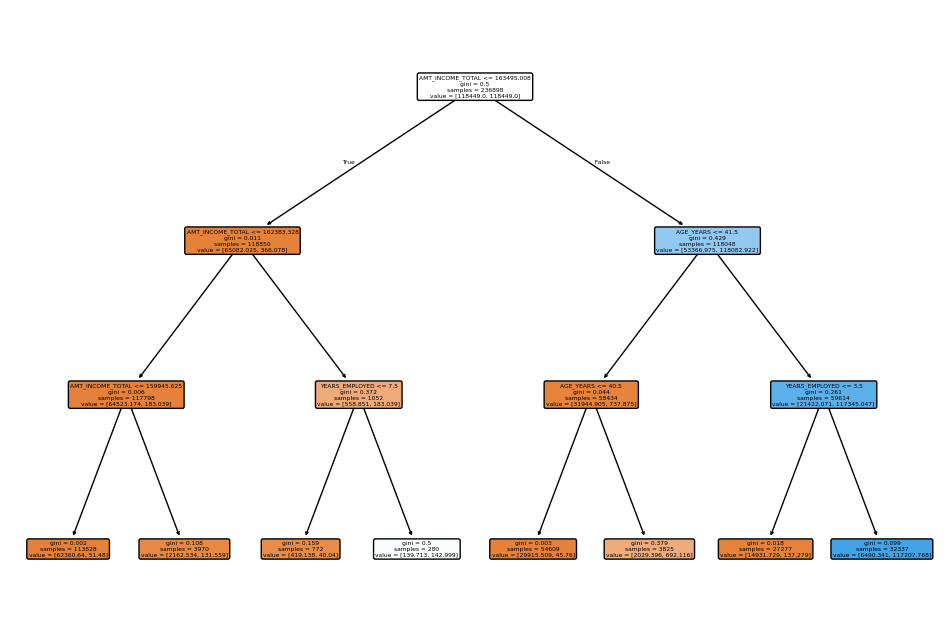

In [ ]:
# Feature Importance DecisionTree
feature_importance = pd.DataFrame({
    'Feature': X_en_df.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance for Random Forest:")
print(feature_importance.head(10))

from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names= X_en_df.columns, filled=True, rounded=True)
plt.show()

* The numerical variables appear to have a greater relative weight on the classification outcome. Specifically, annual income seems to dominate, followed by age and employment date.